In [1]:
import tensorflow as tf
import numpy as np
from galaxy2galaxy import problems
import matplotlib.pyplot as plt

In [2]:
fact = 100

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 2 arrays: an array of noisy galaxy images, 
    and an array of target galaxy images

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of noisy galaxy images, 
        and an array of target galaxy images
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    
    # Compute std of noise for a varying range of SNR
    # By definition - SNR(x) = max(x)/std(x)
    sigma_noise = (tf.math.reduce_max(tf.math.abs(dico['targets'])) / 
                   tf.random.uniform(shape=[], minval=1, maxval=50, dtype=tf.float32, seed=None))
    
    Noisemap = tf.random_normal(shape=(np.shape(dico['targets'])),
                                mean=0.0, 
                                stddev=sigma_noise, 
                                dtype=tf.float32)

    dico['inputs'] = dico['targets'] + Noisemap
    dico['inputs'] *= fact
    dico['targets'] *= fact

    return dico['inputs'], dico['targets']

In [3]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('meerkat_3600')
    dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/meerkat_3600')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 32
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


### Load U-Net Model

In [4]:
model = tf.keras.models.load_model('Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}', compile=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Results

In [5]:
# The model can be applied like so
res = model(batch[0].astype('float32'))

# This should return the solution of the deconvolution problem
res_np = tf.keras.backend.eval(res).squeeze(axis=-1)  

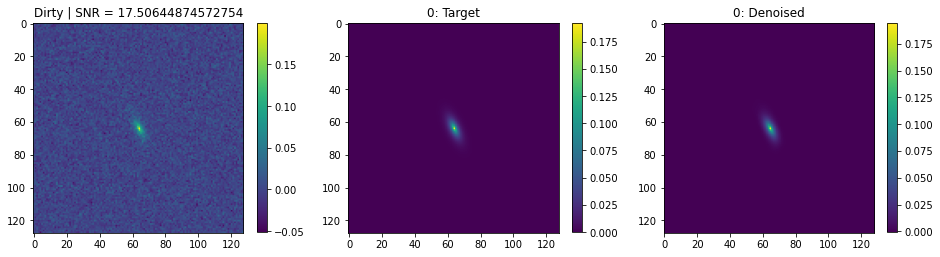

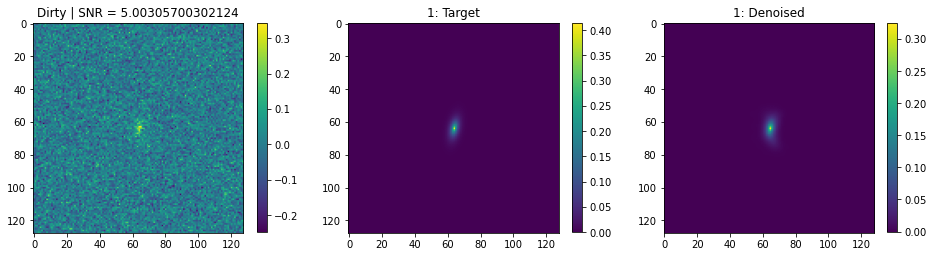

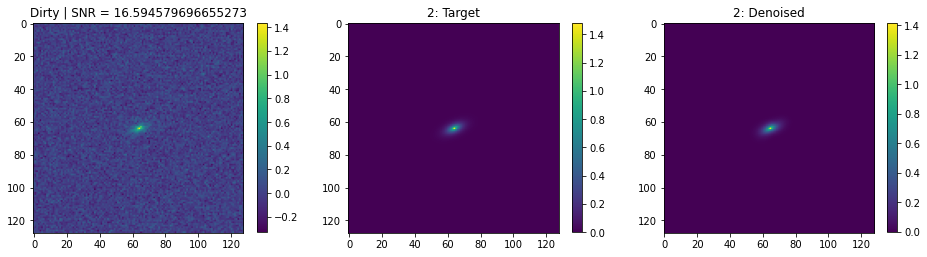

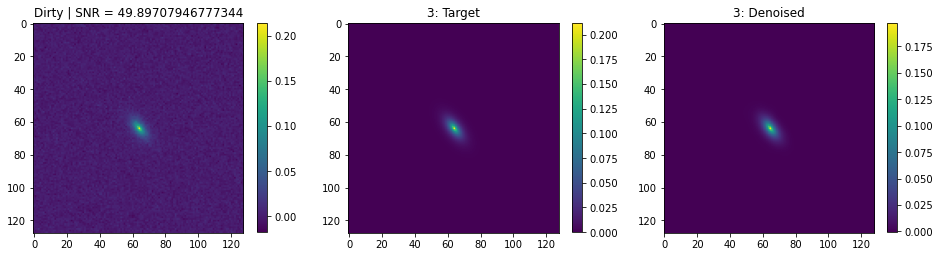

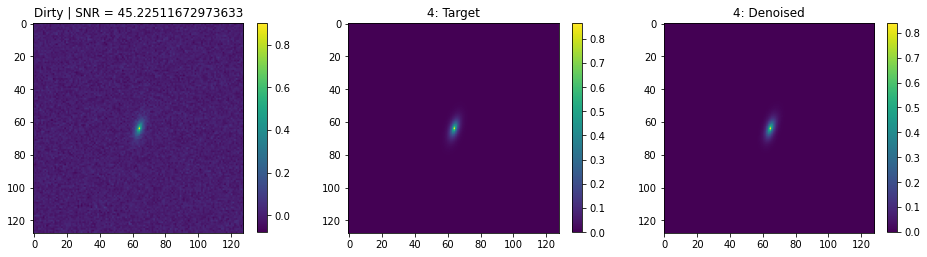

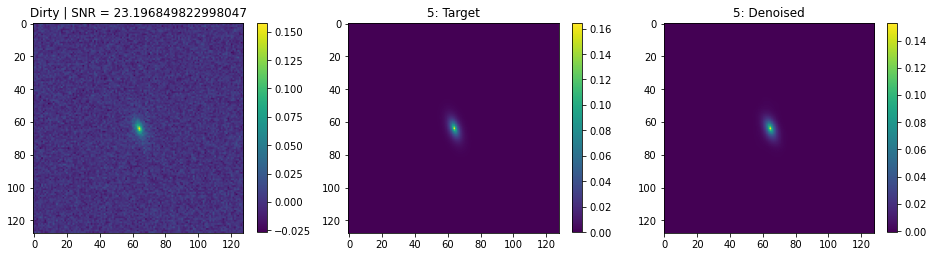

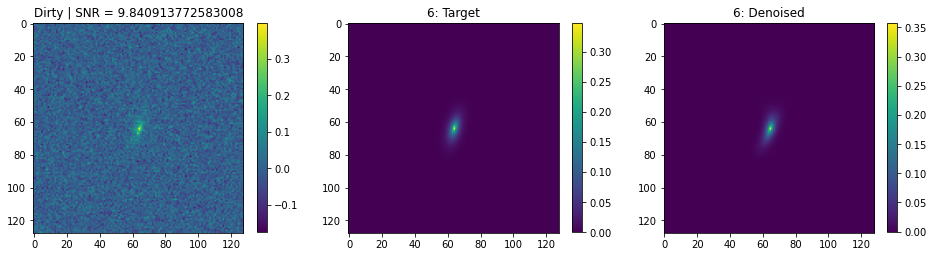

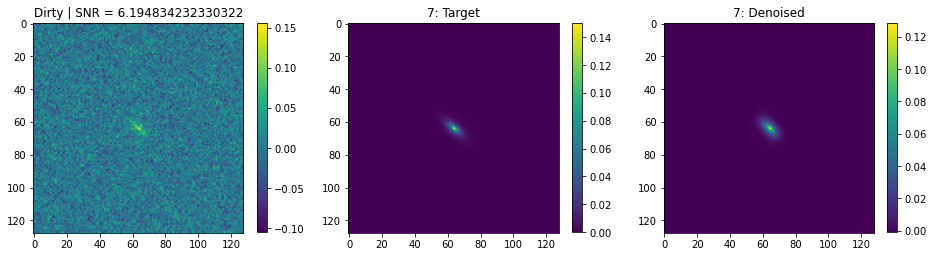

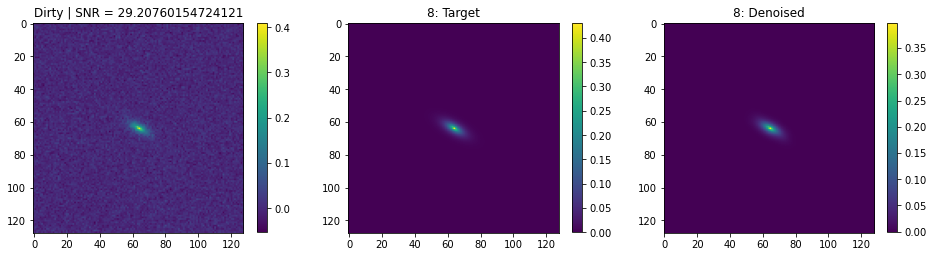

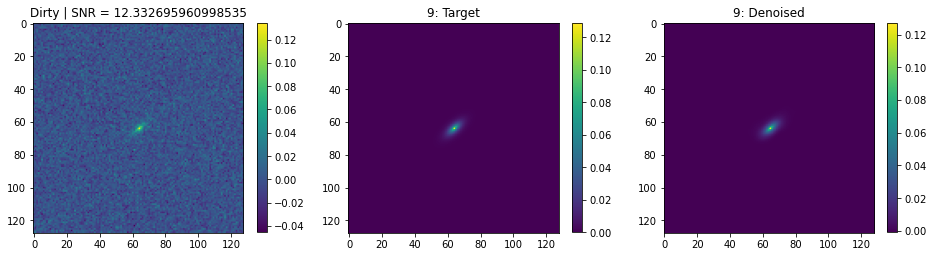

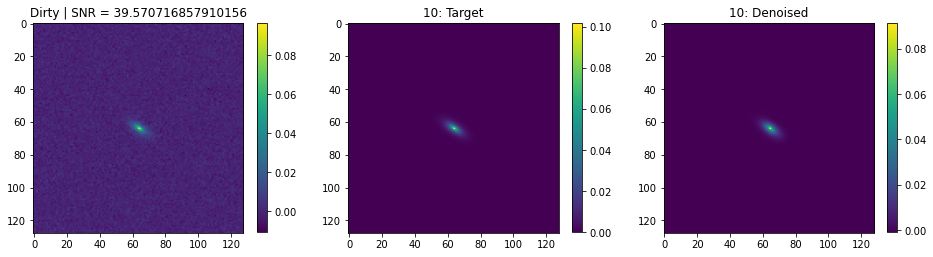

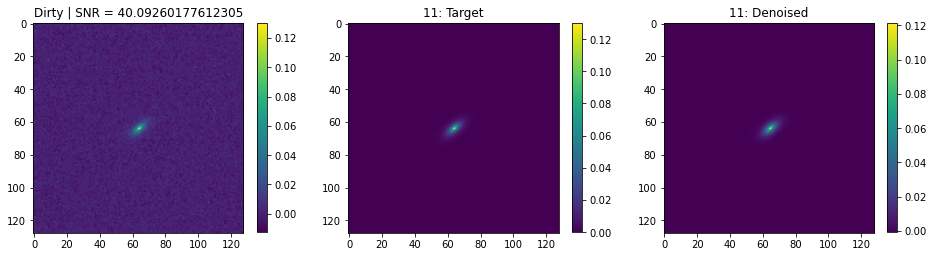

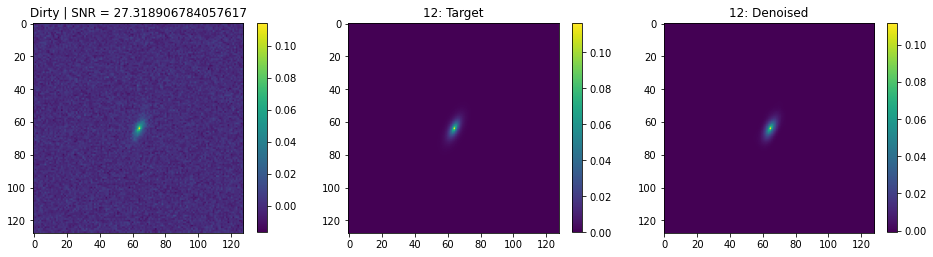

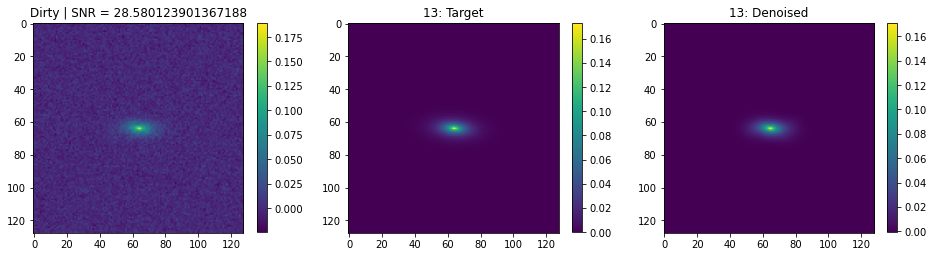

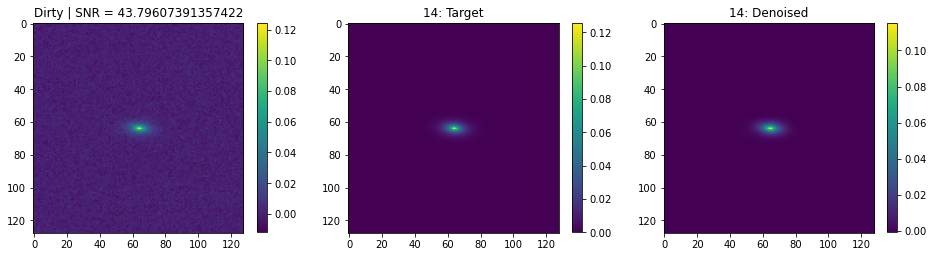

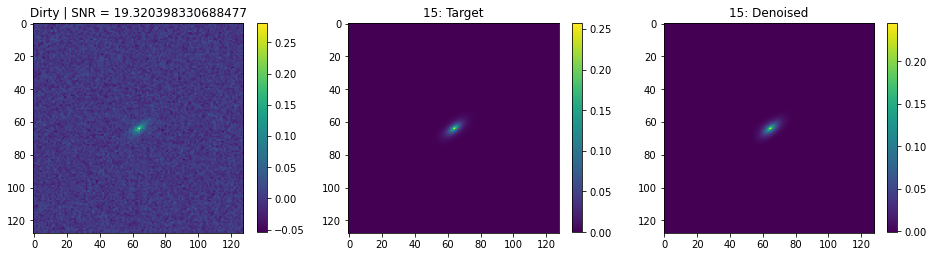

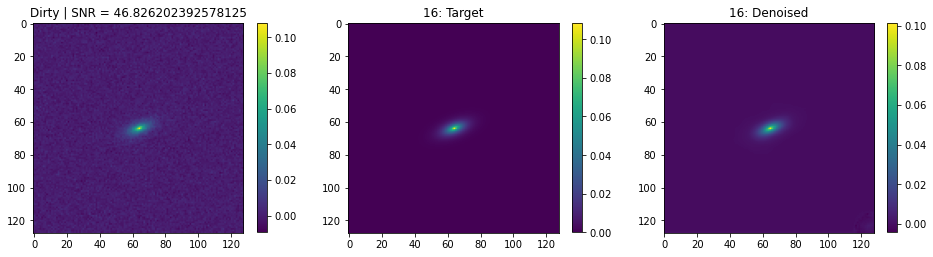

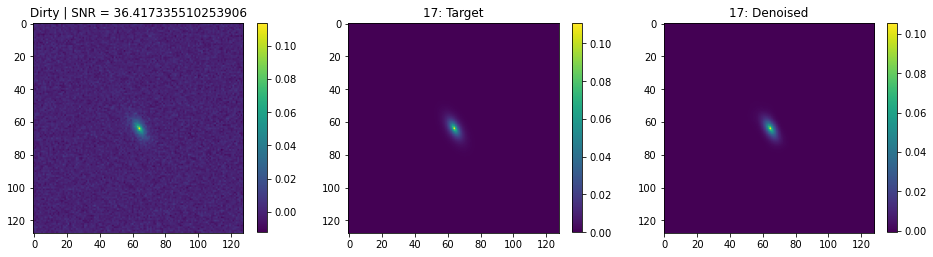

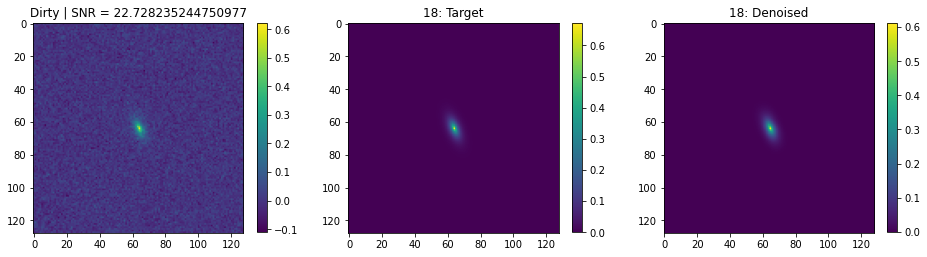

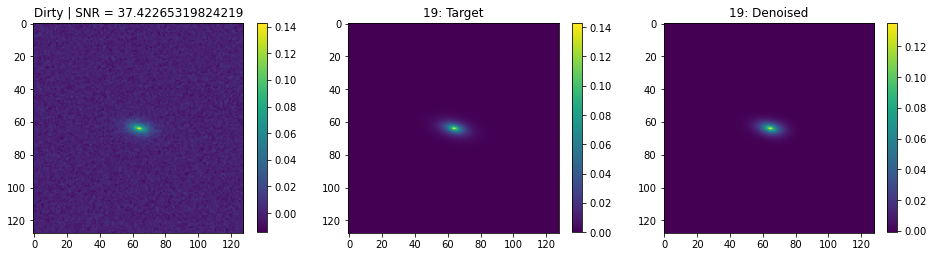

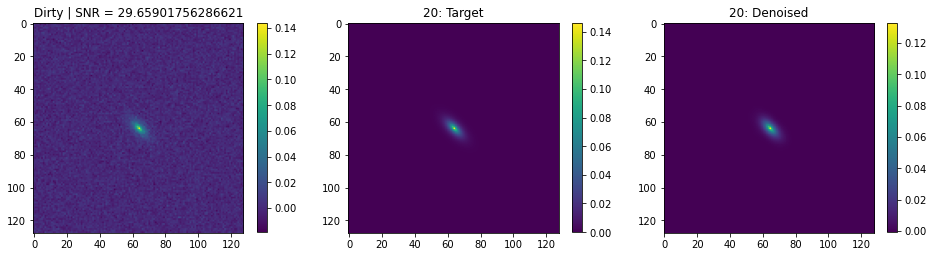

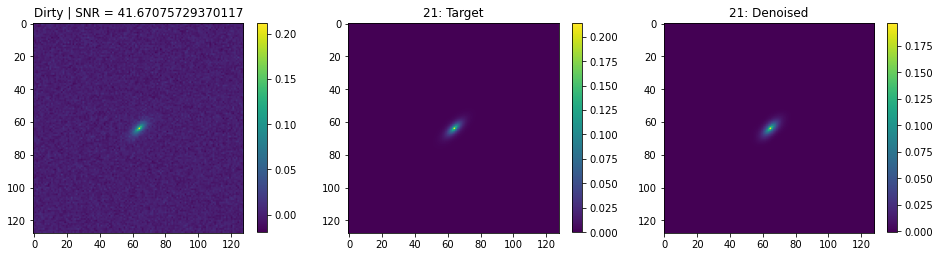

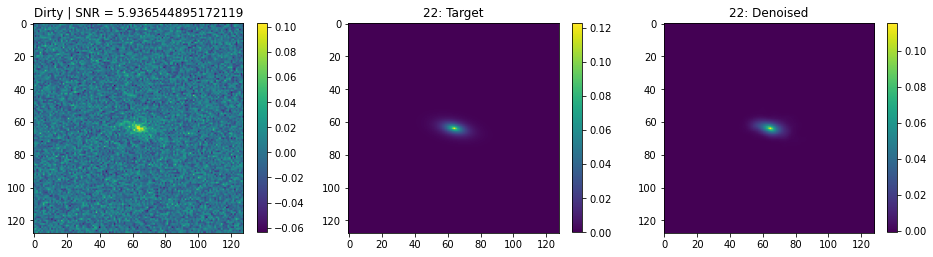

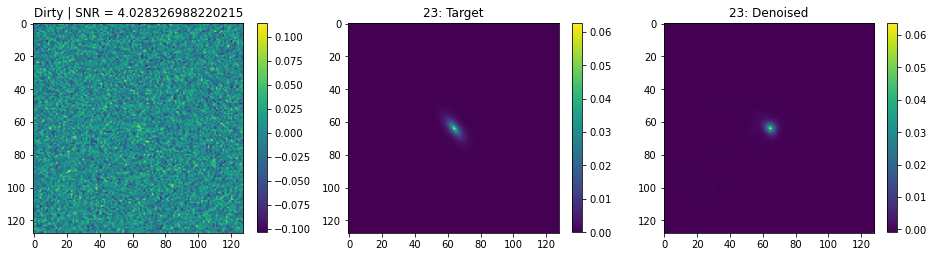

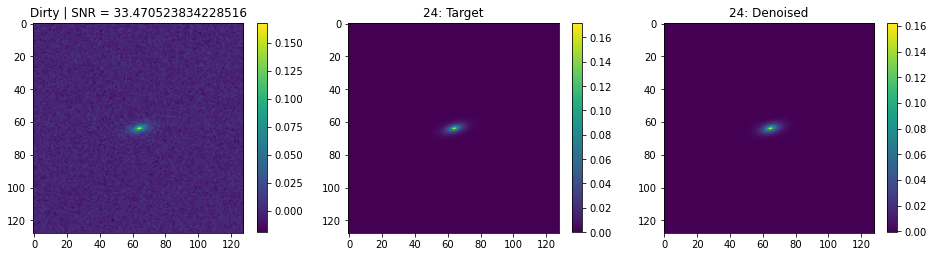

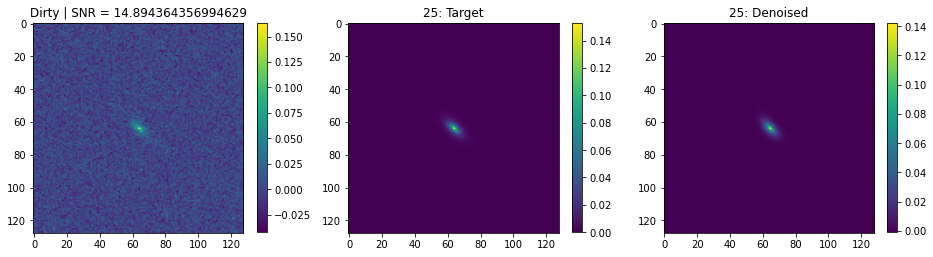

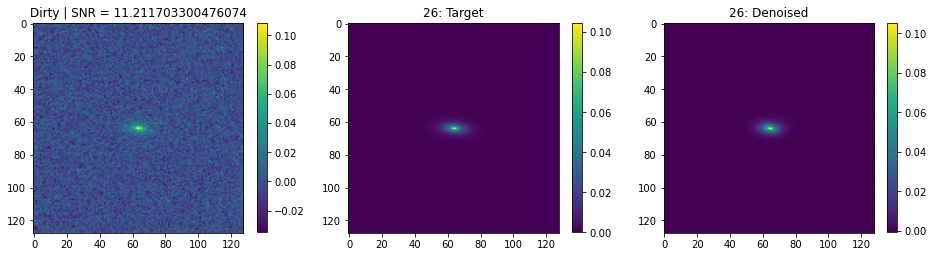

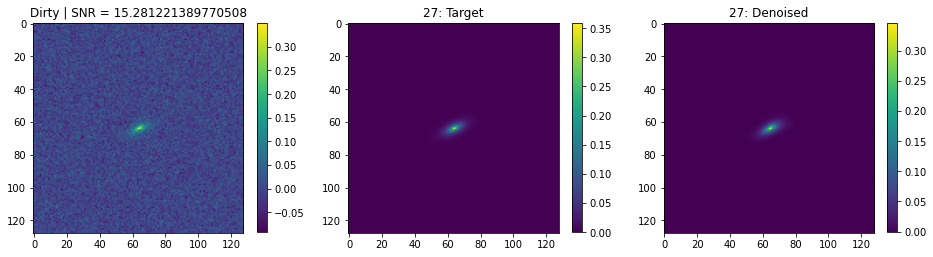

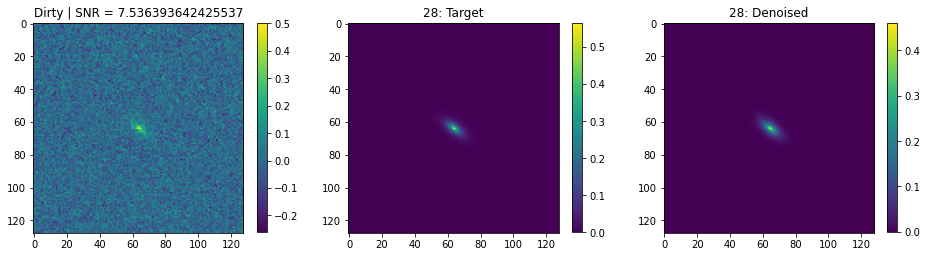

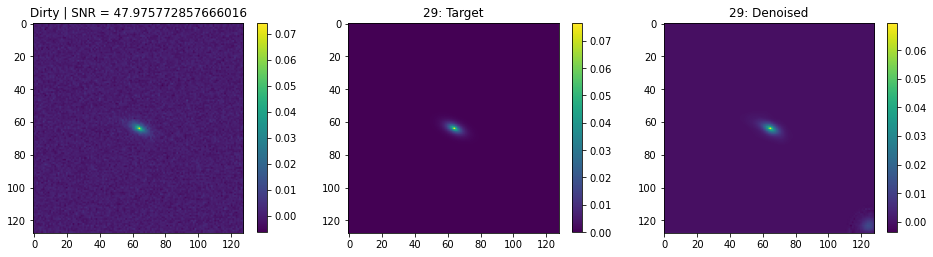

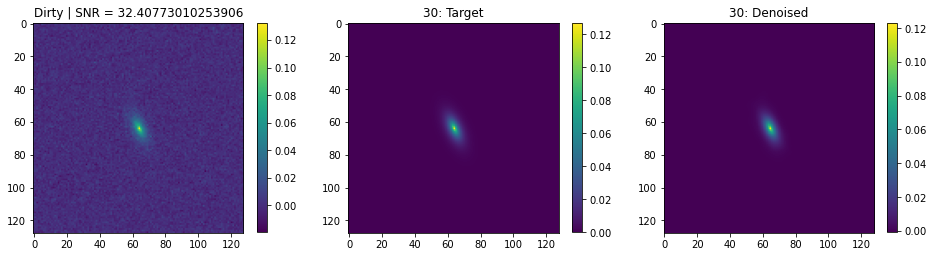

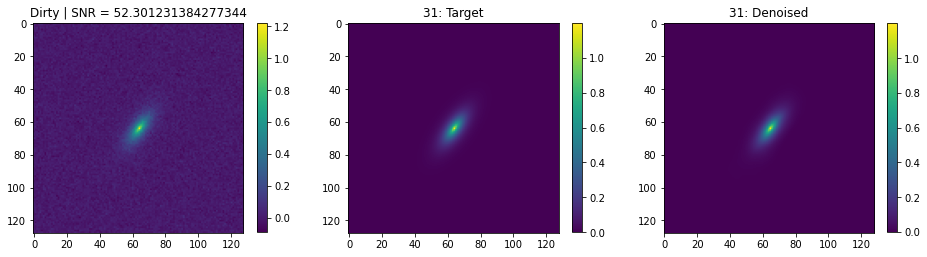

In [6]:
# Look at a few results
for index in range(n_batch):
    dirty = batch[0][index]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    fig = plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(batch[0][index].squeeze(axis=-1))
    plt.title('Dirty | SNR = {}'.format(SNR))
    plt.colorbar(shrink=0.24)
    plt.subplot(132)
    plt.imshow(batch[1][index].squeeze(axis=-1))
    plt.title('{}: Target'.format(index))
    plt.colorbar(shrink=0.24)
    plt.subplot(133)
    plt.imshow(res_np[index])
    plt.title('{}: Denoised'.format(index))
    plt.colorbar(shrink=0.24)
    plt.show(fig)    